In [3]:
from datetime import datetime
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
panels_df = pd.read_csv("../output/all_panels.csv", index_col=0)

In [5]:
panels_df.head()

,machine_id,household_income,racial_background,stratify,panel_id
0,215349037.0,1,1.0,"1.0, 1.0",0
1,186981885.0,1,1.0,"1.0, 1.0",0
2,219531739.0,1,1.0,"1.0, 1.0",0
3,173181751.0,1,1.0,"1.0, 1.0",0
4,202252399.0,1,1.0,"1.0, 1.0",0


In [11]:
# assuming we use 12 weeks of data, how large will our panel of data be?
print(panels_df.groupby('panel_id')['machine_id'].count())
N_machines = panels_df.groupby('panel_id')['machine_id'].count()[0]
print("\n%s = N machines per panel" % N_machines)
print("%s = 12 x N machines per panel" % (12*N_machines))

panel_id
0      23670
1      23670
2      23670
3      23670
4      23670
       ...  
495    23670
496    23670
497    23670
498    23670
499    23670
Name: machine_id, Length: 500, dtype: int64

23670 = N machines per panel
284040 = 12 x N machines per panel


In [12]:
import floc

# sanity check: The same host list used in the GO and python implementations generate
# the same cohort ID
host_list = [
    'www.nikkei.com',
    'jovi0608.hatenablog.com',
    'www.nikkansports.com',
    'www.yahoo.co.jp',
    'www.sponichi.co.jp',
    'www.cnn.co.jp',
    'floc.glitch.me',
    'html5.ohtsu.org',
]
assert(floc.simulate(host_list) == 21454)

# here is an example of a domain list for a cohort deemed sensitive
sensitive_cohort_domain_list = [
    "www.dominos.com",
    "shop.lululemon.com",
    "www.homedepot.com",
    "www.ticketliquidator.com",
    "www.livenation.com",
    "www.tracfone.com",
    "www.officedepot.com"
]
try:
    floc.simulate(sensitive_cohort_domain_list)
except Exception as e:
    print("SimulateError:", e)
floc.simulate(sensitive_cohort_domain_list, check_sensiveness=False)

SimulateError: blocked


24884

## Compute cohorts

Make table mapping machine_ids to domains.

TODO: update this step to use the real sessions data (once we have it)

Here we make fake sessions/domains data, by using the transactions data. Here the domains are the domains where the transactions for a user were made.

But we need at least 7 domains and most user data is sparse... so we insert more domains into a user's weekly domain history.

In [13]:
transactions_fpath = '../data/comscore/2017/transactions.csv'
transactions_df = pd.read_csv(transactions_fpath,
                              parse_dates=['event_date'],
                              encoding="ISO-8859-1")[
    ['machine_id', 'event_date', 'domain_name']
]
(transactions_df
 .drop('machine_id',axis=1)
 .dropna()
).head()

/Users/aberke/projects/floc-analysis/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,event_date,domain_name
25,2017-01-04,verizonwireless.com
26,2017-03-22,verizonwireless.com
27,2017-01-07,verizonwireless.com
28,2017-03-13,verizonwireless.com
29,2017-02-28,verizonwireless.com


In [14]:
tdf = (transactions_df
 .assign(week=lambda x: x.event_date.dt.week)
 .dropna()
 .groupby(['machine_id', 'week'])
 .agg({'domain_name': set}).reset_index()
       .assign(n_domains=lambda x: x.domain_name.map(len))
       .assign(domain_name=lambda x: x.domain_name.map(lambda y: "|".join(list(y))))
      )

/Users/aberke/projects/floc-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [15]:
(tdf
 .sort_values('n_domains', ascending=False)
 .drop('machine_id', axis=1)
).head(10)

,week,domain_name,n_domains
24571,10,toysrus.com|ebay.com|macys.com|gap.com|ups.com...,8
40382,12,expedia.com|dominos.com|avis.com|amazon.com|en...,7
22464,1,bestwestern.com|dickssportinggoods.com|choiceh...,7
22470,7,dickssportinggoods.com|ebay.com|walmart.com|be...,6
13162,1,sephora.com|carters.com|6pm.com|gap.com|amazon...,6
1275,5,lowes.com|overstock.com|etsy.com|walmart.com|a...,5
11114,4,bestwestern.com|ticketmaster.com|dominos.com|t...,5
22543,1,dsw.com|yahoo.net|hertz.com|searspartsdirect.c...,5
24967,10,shutterfly.com|disneystore.com|qvc.com|amazon....,5
17162,8,etsy.com|shutterfly.com|officedepot.com|carter...,5


There are not enough domains per machine ^.

Pad the domain histories for each machine to have at least 7 per machine.

In [16]:
import itertools
unique_domains = list(set(itertools.chain(*[d.split("|") for d in tdf.domain_name])))

def pad_domains(l, s):
    n = 7 - len(l)
    if n > 0:
        return list(l) + list(np.random.choice(s, n))
    else:
        return l

tdf['padded_domains'] = tdf.apply(lambda x: pad_domains(x.domain_name.split("|"), unique_domains), axis=1)

In [17]:
(tdf
 .sort_values('n_domains', ascending=False)
 .drop('machine_id', axis=1)
).head(5)

,week,domain_name,n_domains,padded_domains
24571,10,toysrus.com|ebay.com|macys.com|gap.com|ups.com...,8,"[toysrus.com, ebay.com, macys.com, gap.com, up..."
40382,12,expedia.com|dominos.com|avis.com|amazon.com|en...,7,"[expedia.com, dominos.com, avis.com, amazon.co..."
22464,1,bestwestern.com|dickssportinggoods.com|choiceh...,7,"[bestwestern.com, dickssportinggoods.com, choi..."
22470,7,dickssportinggoods.com|ebay.com|walmart.com|be...,6,"[dickssportinggoods.com, ebay.com, walmart.com..."
13162,1,sephora.com|carters.com|6pm.com|gap.com|amazon...,6,"[sephora.com, carters.com, 6pm.com, gap.com, a..."


### Apply simhash

Using steps from https://github.com/shigeki/floc_simulator/blob/292fe1beb8a827f27a96dc951345a5c1cfb8da56/demos/floc_sample/main.go

```
var kMaxNumberOfBitsInFloc uint8 = 50
sim_hash := floc.SimHashString(domain_list, kMaxNumberOfBitsInFloc)
```

In [19]:
kMaxNumberOfBitsInFloc = 50
floc.hashes.sim_hash_string

<function floc.hashes.sim_hash_string(domains: List[str], k_max_numbers_of_bits_in_floc: int = 50) -> int>

In [20]:
tdf['simhash'] = tdf.padded_domains.apply(floc.hashes.sim_hash_string)
(tdf
 .sort_values('simhash', ascending=False)
 .drop(['machine_id', 'week'], axis=1)
).head(5)

,domain_name,n_domains,padded_domains,simhash
40204,aa.com,1,"[aa.com, lakeside.com, hotwire.com, att.com, j...",1125676033592074
22885,amazon.com,1,"[amazon.com, ftd.com, fingerhut.com, hsn.com, ...",1125614727690250
9911,amazon.com,1,"[amazon.com, hsn.com, jcpenney.com, jet.com, w...",1125611309348226
33871,booking.com,1,"[booking.com, jcpenney.com, kay.com, jjill.com...",1125253885742882
18877,marriott.com,1,"[marriott.com, shopmyexchange.com, hsn.com, jc...",1125245138221408


Assign cohort IDs by applying the prefixLSH algorithm on all of the eligible machines in the panel.

Note: In the browser implementation, the sorting has already been done and the browser has a clusters data file. The browser then queries for the specific cohort ID for a machine based on this clusters data.

This is necessary for the real-world deployment.

The clusters data file is not necessary for this analysis.

Here we do the sorting and assignment together.

In [21]:
def binary_hash(h):
    return np.binary_repr(h, width=kMaxNumberOfBitsInFloc)

In [23]:
simhashes = tdf['simhash']
print(np.binary_repr(simhashes[0]))
print(len(np.binary_repr(simhashes[0])))

# some sanity checks

# check that all simhashes have binary representation less than 50 bits
for _i, simhash in enumerate(simhashes):
    assert(len(np.binary_repr(simhash)) <= 50)
    
# check that the ordering of the simhashes is the same for binary
# actually this will only work when we pad the higher bits with zeros
# as in the binary_hash implementation
sorted_simhashes = sorted(simhashes)
for i in range(1, len(simhashes)):
    assert(binary_hash(sorted_simhashes[i-1]) <= binary_hash(sorted_simhashes[i]))
    assert(sorted_simhashes[i-1] <= sorted_simhashes[i])
    
# sorted_simhashes

100110001011001000101010001001110001000011011010
48


Get a mapping from the simhashes to their cohorts, where this is determined by sorting all of the simhashes with prefixLSH.

In [42]:
import prefixLSH


cohorts_dict = prefixLSH.get_cohorts_dict(tdf['simhash'])
tdf["cohort"] = tdf['simhash'].map(cohorts_dict)

print("%s cohorts" % tdf["cohort"].nunique())
assert(tdf["cohort"].max() == tdf["cohort"].nunique())

print("%s samples (rows)" % len(tdf))
print("%0.1f avg samples per cohort" % (len(tdf)/tdf["cohort"].nunique()))

tdf.head()

476 cohorts
43880 samples (rows)
92.2 avg samples per cohort


,machine_id,week,domain_name,n_domains,padded_domains,simhash,cohort
0,46569906,8,amazon.com,1,"[amazon.com, uhaul.com, walmart.com, ulta.com,...",167890978803930,121
1,46569906,12,amazon.com|nordstromrack.com,2,"[amazon.com, nordstromrack.com, jjill.com, nor...",186572767891310,138
2,70298839,12,ebay.com,1,"[ebay.com, mcafee.com, zales.com, eventbrite.c...",176031626721700,130
3,100607252,11,dominos.com,1,"[dominos.com, lowes.com, avon.com, lanebryant....",748381777952488,377
4,119721244,8,amazon.com,1,"[amazon.com, snapfish.com, hotwire.com, roaman...",267263370136316,194


275    234
220    226
369    224
372    209
273    208
      ... 
339     50
125     50
359     50
300     50
391     50
Name: cohort, Length: 476, dtype: int64

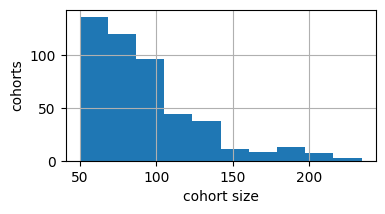

In [49]:
fig,ax = plt.subplots(1,1,figsize=(4,2), dpi=100)
tdf["cohort"].value_counts().hist(ax=ax)
plt.ylabel("cohorts")
plt.xlabel("cohort size")

tdf["cohort"].value_counts()